In [2]:
import pandas as pd
from fastai.tabular import *
from fastai.basic_train import *
from fastai.metrics import *
import numpy as np
import matplotlib.pyplot as plt
import torch, time
import torch.nn as nn
torch.cuda.set_device(1)

# Weight initialization

In [3]:
D = np.random.randn(1000,500)
hidden_layer_sizes = [500]*5
nonlinearities = ['tanh']*len(hidden_layer_sizes)

In [4]:
act = {'relu':lambda x:np.maximum(0,x), 'tanh':lambda x:np.tanh(x)}
Hs = {}
for i in range(len(hidden_layer_sizes)):
    X = D if i ==0 else Hs[i-1]
    fan_in = X.shape[1]
    fan_out = hidden_layer_sizes[i]
    W = np.random.randn(fan_in,fan_out)*0.01 # * np.sqrt( 2 / (fan_in + fan_out )) 
    
    H = np.dot(X, W)
    H = act[nonlinearities[i]](H)
    Hs[i] = H

input layer had mean -0.000983 and std 0.999983
hidden layer 1 had mean 0.000308 and std 0.213384
hidden layer 2 had mean -0.000009 and std 0.047592
hidden layer 3 had mean 0.000001 and std 0.010628
hidden layer 4 had mean -0.000004 and std 0.002391
hidden layer 5 had mean 0.000000 and std 0.000533


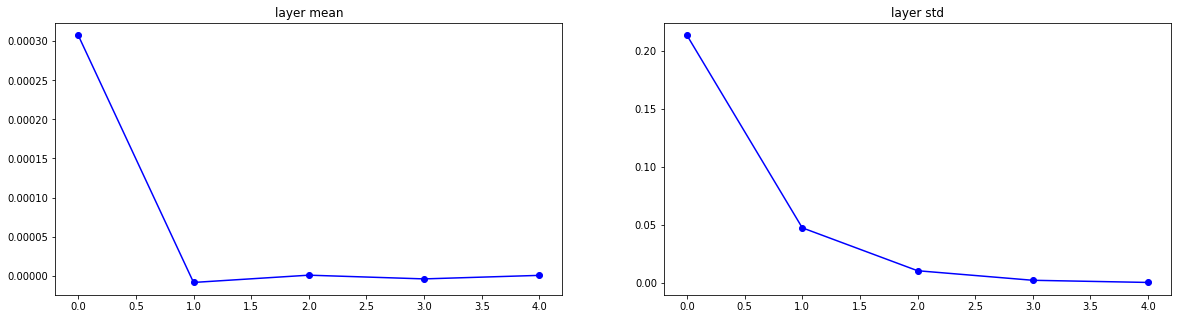

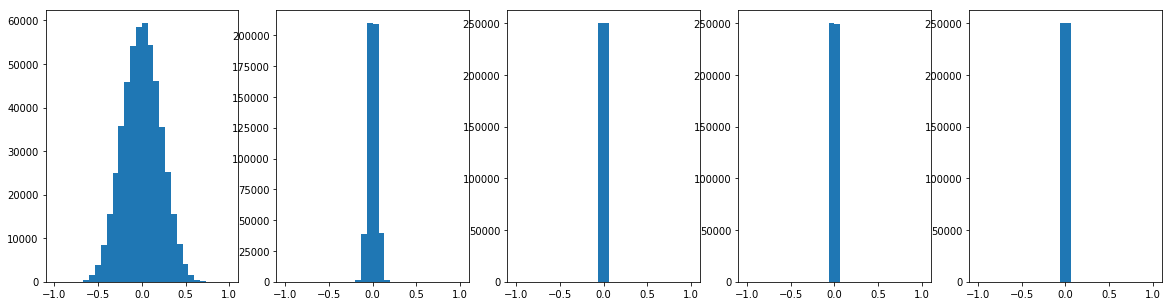

In [5]:
print('input layer had mean %f and std %f' % (np.mean(D),np.std(D)))
layer_means = [np.mean(H) for i,H in Hs.items()]
layer_stds = [np.std(H) for i,H in Hs.items()]
for i,H in Hs.items():
    print('hidden layer %d had mean %f and std %f'
          % (i+1, layer_means[i],layer_stds[i]))
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(Hs.keys(),layer_means,'ob-')
plt.title('layer mean')
plt.subplot(122)
plt.plot(Hs.keys(),layer_stds,'ob-')
plt.title('layer std')

plt.figure(figsize=(20,5))
for i,H in Hs.items():
    plt.subplot(1,len(Hs),i+1)
    plt.hist(H.ravel(),30,(-1,1))

# HiggsML dataset - model optimization

In [ ]:
#download the data
!wget http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz
!gunzip atlas-higgs-challenge-2014-v2.csv.gz

In [6]:
#Read the data (the input file contains ~820k different events)
raw_df = pd.read_csv('atlas-higgs-challenge-2014-v2.csv')

In [7]:
#remove unnecessary variables
df = raw_df.drop('EventId',axis=1).drop('Weight',axis=1).drop('KaggleSet',axis=1).drop('KaggleWeight',axis=1)
#keep only PRI_jet_num=2 entries
df = df.loc[df.PRI_jet_num>1]

### Split to training/validation/test

we will split our dataset to three parts.

In [8]:
training_df = df[:150000]
valid_df = df[150000:200000]
test_df = df[200000:]
#lets see how many signal and bkg events we have
for df_i in [training_df,valid_df,test_df]:
    print(len(df_i),' signal: ',len(df_i[df_i.Label=='s']), ' bkg: ',len(df_i[df_i.Label=='b']))
    print('-----')

150000  signal:  67076  bkg:  82924
-----
50000  signal:  22441  bkg:  27559
-----
37985  signal:  16988  bkg:  20997
-----


# Define the variables of the dataset

the dep_var (dependent variable) is what we want to predict,

cat_names stands for "categorical names", variables which describe distinct cateogries
cont_names is "continuous", for variables which are continuous...

we don't HAVE to make this distinction, but it might be usefull, especially in cases with many cateogries (not this one)

In [9]:
dep_var = 'Label'
cat_names = None
cont_names = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_jet_num', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']

### Create the dataset object

note we add something called "Categorify" as a "proc"
this is something technical I don't want to get into here, you need it when using categorical variables that are not integers.

In [10]:
valid_idx = range(len(training_df), len(training_df)+len(valid_df))

procs = [Categorify]

data = TabularDataBunch.from_df('.', pd.concat([training_df,valid_df]), dep_var=dep_var, 
                                valid_idx=valid_idx, cat_names=cat_names,
                                cont_names=cont_names,procs=procs,
                               bs=400) #notice the bs = batch size

# Learner (train function)

In ex. 1 we used `Learner()` from [basic_train](https://docs.fast.ai/basic_train.html#Learner) library

note: we defined `loss_func` to be CrossEntropy(), and not BinaryCrossEntropy.

We construct a simple NN, for the propose we will use 4-Layer NN with H = [100,50,10]
![4-Layer NN](images/4L_NN.png)

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
               
        self.activation = nn.Tanh()
        self.layer1 = nn.Linear(30,100)
        self.layer2 = nn.Linear(100,50)
        self.layer3 = nn.Linear(50,10)
        self.layer4 = nn.Linear(10,2)
        
    def forward(self, x_cat, x_cont):
        
        out = self.activation( self.layer1(x_cont) )
        out = self.activation( self.layer2(out) )
        out = self.activation( self.layer3(out) )
        out = self.layer4(out)
        return out

In [12]:
net = Net()
learn = Learner(data,net,metrics=accuracy, loss_func=nn.CrossEntropyLoss(), opt_func=optim.SGD)

### Train and evaluate

if we run the learning rate finder with this model, it obiously does not matter what learning rate we use, since the output is always "background"

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


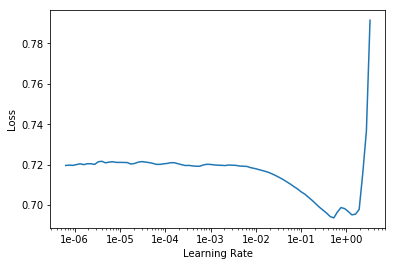

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
tic = time.time()
learn.fit(10, 5e-3)
toc = time.time()
print('total time: %2.2f sec' %(toc-tic))

epoch,train_loss,valid_loss,accuracy,time
0,0.608867,0.598804,0.689600,00:02
1,0.563393,0.558542,0.719160,00:02
2,0.547530,0.543153,0.728660,00:03
3,0.538103,0.536191,0.733180,00:02
4,0.533265,0.529133,0.735800,00:02
5,0.534568,0.527300,0.740200,00:02
6,0.522705,0.521674,0.743660,00:02
7,0.524715,0.520094,0.744740,00:02
8,0.515006,0.520334,0.744720,00:02
9,0.519312,0.520079,0.742660,00:02


total time: 28.57 sec


###  Lets look at the prediction

to run the train function we need to define the loss and optimizer

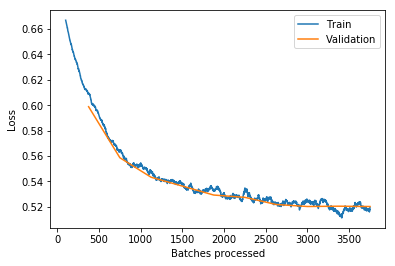

In [15]:
learn.recorder.plot_losses(skip_start=100)

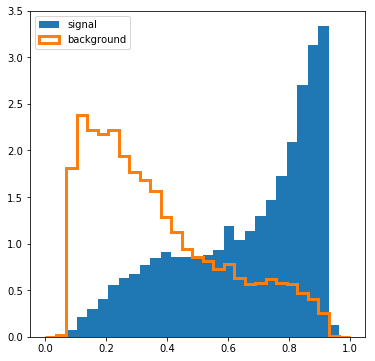

In [16]:
preds,y = learn.get_preds(ds_type=DatasetType.Valid)
preds = preds.data.numpy()[:,0]

preds_sig = preds[y.numpy()==0]
preds_bkg = preds[y.numpy()==1]

bins = np.linspace(0,1,30)

fig,ax = plt.subplots(figsize=(6,6))

ax.hist(preds_sig,bins=bins,density=True,label='signal')
ax.hist(preds_bkg,bins=bins,density=True,histtype='step',linewidth=3,label='background')
plt.legend()
plt.show()

# Batch Normalization 

We will repeat all steps, just this time the data will be reprocessed with the "Normalize" transformations


In [17]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
               
        self.activation = nn.Tanh()
        self.batch_norm1 = nn.BatchNorm1d(30)
        self.batch_norm2 = nn.BatchNorm1d(100)
        self.batch_norm3 = nn.BatchNorm1d(50)
        self.batch_norm4 = nn.BatchNorm1d(10)
        self.layer1 = nn.Linear(30,100, bias=False)
        self.layer2 = nn.Linear(100,50, bias=False)
        self.layer3 = nn.Linear(50,10, bias=False)
        self.layer4 = nn.Linear(10,2, bias=False)
        
    def forward(self, x_cat, x_cont):
        
        out = self.batch_norm1(x_cont)
        out = self.activation( self.layer1(out) )
        out = self.batch_norm2(out)
        out = self.activation( self.layer2(out) )
        out = self.batch_norm3(out)
        out = self.activation( self.layer3(out) )
        out = self.batch_norm4(out)
        out = self.layer4(out)
        return out

net2 = Net2()
learn_norm = Learner(data, net2, metrics=accuracy, loss_func=nn.CrossEntropyLoss(), opt_func=optim.SGD)

In [18]:
tic = time.time()
learn_norm.fit(10, 5e-3)
toc = time.time()
print('total time: %2.2f sec' %(toc-tic))

epoch,train_loss,valid_loss,accuracy,time
0,0.572648,0.563448,0.709320,00:03
1,0.533017,0.530750,0.732860,00:03
2,0.524638,0.522592,0.735280,00:03
3,0.524748,0.520760,0.735840,00:03
4,0.522025,0.519003,0.737800,00:03
5,0.520543,0.518479,0.738400,00:03
6,0.521452,0.517408,0.739660,00:03
7,0.518517,0.516587,0.739100,00:03
8,0.518972,0.516496,0.739260,00:03
9,0.516077,0.514739,0.739960,00:03


total time: 32.76 sec


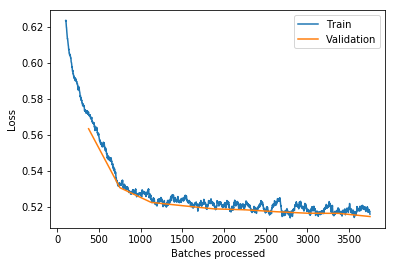

In [19]:
learn_norm.recorder.plot_losses(skip_start=100)

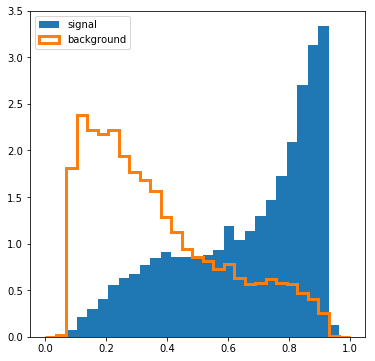

In [20]:
preds,y = learn.get_preds(ds_type=DatasetType.Valid)
preds = preds.data.numpy()[:,0]

preds_sig = preds[y.numpy()==0]
preds_bkg = preds[y.numpy()==1]

bins = np.linspace(0,1,30)

fig,ax = plt.subplots(figsize=(6,6))

ax.hist(preds_sig,bins=bins,density=True,label='signal')
ax.hist(preds_bkg,bins=bins,density=True,histtype='step',linewidth=3,label='background')
plt.legend()
plt.show()

# Optimizer SDG vs Adam

In [21]:
learn_adam = Learner(data, net2, metrics=accuracy, loss_func=nn.CrossEntropyLoss(), opt_func=optim.Adam)

In [22]:
tic = time.time()
learn_adam.fit(10, 5e-3)
toc = time.time()
print('total time: %2.2f sec' %(toc-tic))

epoch,train_loss,valid_loss,accuracy,time
0,0.370373,0.368965,0.835500,00:04
1,0.357557,0.353642,0.844280,00:03
2,0.351732,0.360440,0.839720,00:03
3,0.346628,0.349998,0.847400,00:03
4,0.350835,0.342163,0.850180,00:03
5,0.346237,0.347537,0.847520,00:03
6,0.338051,0.344891,0.848060,00:03
7,0.348190,0.356231,0.842020,00:03
8,0.337508,0.340563,0.852780,00:03
9,0.331573,0.344404,0.849900,00:03


total time: 36.96 sec


# RelU vs TanH

In [23]:
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
               
        self.activation = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(30)
        self.batch_norm2 = nn.BatchNorm1d(100)
        self.batch_norm3 = nn.BatchNorm1d(50)
        self.batch_norm4 = nn.BatchNorm1d(10)
        self.layer1 = nn.Linear(30,100, bias=False)
        self.layer2 = nn.Linear(100,50, bias=False)
        self.layer3 = nn.Linear(50,10, bias=False)
        self.layer4 = nn.Linear(10,2, bias=False)
        
    def forward(self, x_cat, x_cont):
        
        out = self.batch_norm1(x_cont)
        out = self.activation( self.layer1(out) )
        out = self.batch_norm2(out)
        out = self.activation( self.layer2(out) )
        out = self.batch_norm3(out)
        out = self.activation( self.layer3(out) )
        out = self.batch_norm4(out)
        out = self.layer4(out)
        return out

net3 = Net3()
learn_relu = Learner(data, net3, metrics=accuracy, loss_func=nn.CrossEntropyLoss(), opt_func=optim.Adam)

In [24]:
tic = time.time()
learn_relu.fit(10, 5e-3)
toc = time.time()
print('total time: %2.2f sec' %(toc-tic))

epoch,train_loss,valid_loss,accuracy,time
0,0.366466,0.353566,0.844080,00:03
1,0.350571,0.344780,0.848760,00:03
2,0.355863,0.345307,0.849520,00:03
3,0.346383,0.340116,0.851580,00:03
4,0.338881,0.347100,0.847680,00:03
5,0.344844,0.343906,0.849620,00:03
6,0.342050,0.341898,0.849980,00:03
7,0.334233,0.336201,0.853020,00:03
8,0.338937,0.342071,0.849800,00:03
9,0.336712,0.334587,0.853340,00:03


total time: 36.63 sec


# Compare accuracy between four methods

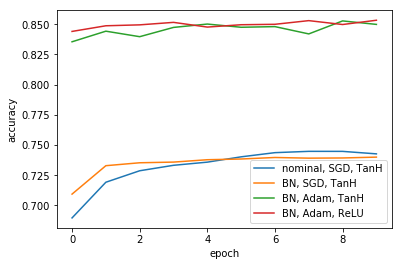

In [41]:
plt.plot(learn.recorder.metrics,label = 'nominal, SGD, TanH')
plt.plot(learn_norm.recorder.metrics,label = 'BN, SGD, TanH')
plt.plot(learn_adam.recorder.metrics,label = 'BN, Adam, TanH')
plt.plot(learn_relu.recorder.metrics,label = 'BN, Adam, ReLU')
plt.legend(); plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.show()